In [1]:
'''
Implemented by Suwon Suh for Posco ZRM project
'''
import numpy as np
rng = np.random



#main
#game = Easy21()
#game.interactive()
#print game.is_finish

#state = game.get_state()
#action = 1 #0:stick, 1:hit
#state, reward = game.step(state, action=0)
#state = game.get_state()


#easy21.step(1,1)
#print easy21.draw_card()


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from time import sleep
import pickle

rng = np.random

class MCControl(object):
    '''
    Monte Carlo Control
    '''
    N_0 = 100.0
    #N_0 = 1.0
    #N_0 = 10.0
    dict_sa_N = {}
    dict_sa_Q = {}
    dict_s_V ={}
    game = None
    num_game = 0.0
    acc_reward =0.0
    avg_reward =[]
    
    
    class Easy21(object):
        """ Simplified Blackjack Game Class"""
        num_play = 0
        num_step = 1
        state_dealer = 0
        state_player = 0
        is_finish    = False
        reward = 0

        def draw_card(self):
            number = rng.randint(10)+1
            if rng.random() > (1.0/3.0):
                rb = 1  #-1:red, 1:black
            else:
                rb = -1
            return number,rb

        def __init__(self):
            self.num_play += 1
            number, rb = self.draw_card()
            self.state_dealer += number #only black
            number, rb = self.draw_card()
            self.state_player += number #only black

        def print_state(self):
            print('step:' +str(self.num_step))
            print('dealer state:' + str(self.state_dealer))
            print('player state:' + str(self.state_player))
            print('reward:' + str(self.reward))
            if self.is_finish:
                print('Finished!')
            else:
                print('On game.')
        def get_state(self):
            self.print_state()
            return (self.state_dealer,self.state_player)

        def step(self, state , action):
            #self.print_states()
            self.num_step += 1
            if action == 0:
                self.reward = self.finalize()
                return (self.state_dealer, self.state_player), self.reward
            elif action == 1:
                number, rb = self.draw_card()
                self.state_player += number * rb
                if self.state_player > 21:
                    self.reward = -1
                    self.is_finish = True
                if self.state_player < 1:
                    self.reward = -1
                    self.is_finish = True
                return (self.state_dealer,self.state_player), self.reward
        
        def finalize(self):
            self.is_finish = True
            while self.state_dealer < 17:
                number, rb = self.draw_card()
                self.state_dealer += number * rb
                if self.state_dealer < 1:
                    return 1
            if self.state_dealer > 21:
                return 1
            if self.state_dealer < self.state_player:
                return 1
            elif self.state_dealer == self.state_player:
                return 0
            elif self.state_dealer > self.state_player:
                return -1
        def interactive(self):
            while self.is_finish == False:
                state = self.get_state()
                action = input("stick or hit(0/1):")
                state, reward = self.step(state, action)
            self.get_state()

            
    def __init__(self):
        rng.seed(123)
        pass

    def get_control(self,state):
        #epsilon-greedy optimal control
        epsilon = self.N_0 /(self.N_0 + self.getN(state,0)+ self.getN(state,1))
        #epsilon = 0.1
        if( np.random.random() > float(epsilon)):
            #optimal policy
            if(self.getQ(state,0) > self.getQ(state,1)):
                return 0
            else:
                return 1
        else:
            #random policy
            if(np.random.random() > 0.5):
                return 0
            else:
                return 1

    def simulate(self, num_iters):
        for i in range(num_iters):
            self.simulate_once()
            if i % 100000 == 0:
                print('show')
                self.showV()
                self.saveQ()

    def simulate_once(self):
        self.num_game += 1
        self.game = self.Easy21()
        sas = []
        state = self.game.get_state()                # initial state
        action = self.get_control(state)             # control
        sas.append((state,action))
        print('initial state and action:', state, action)
        state, reward = self.game.step(state, action) # environment gives the next state and reward
        while self.game.is_finish == False:
            print('state, reward, is_finish', state, reward, self.game.is_finish)
            action = self.get_control(state)         # agent choose the epsilon greedy control
            sas.append((state,action))
            print(state, action)
            state, reward = self.game.step(state,action) # environment gives the next state and reward
            print(state, reward, self.game.is_finish)
        #self.game.print_state()
        self.acc_reward += reward

        # accumulate this episode in data structure N and Q
        for i,(state,action) in enumerate(sas):
            print('number, state, action, reward:', i, state, action, reward)
            self.updateN(state,action)
            #there is no discount weights.
            self.updateQ(state,action,reward)
        avg_reward = self.acc_reward /self.num_game
        self.avg_reward.append(avg_reward)
        print('# of games played:' +str(int(self.num_game))+' average reward:' + str(avg_reward))
        print('state-action visit number:', self.dict_sa_N)
        print('action value function:', self.dict_sa_Q)

    def updateN(self,state,action):
        key = (state,action)
        if key in self.dict_sa_N:
            self.dict_sa_N[key] += 1
            print(key, self.dict_sa_N[key])
        else:
            self.dict_sa_N[key] = 1

    def getN(self,state,action):
        key = (state,action)
        if key in self.dict_sa_N:
            return self.dict_sa_N[key]
        else:
            return 0

    def updateQ(self,state,action,reward):
        alpha =1.0/float(self.getN(state,action))
        key = (state,action)
        if key in self.dict_sa_Q:
            self.dict_sa_Q[key] = self.dict_sa_Q[key] + alpha * ( reward - self.dict_sa_Q[key])
        else:
            self.dict_sa_Q[key] = alpha * ( reward )

    def getQ(self,state,action):
        key = (state,action)
        if key in self.dict_sa_Q:
            return self.dict_sa_Q[key]
        else:
            return 0
    def saveQ(self):
        pickle.dump( self.dict_sa_Q, open( "MC_action_value_Q_func.p", "wb" ) )

    def buildV(self):
        X = np.zeros((10,21),dtype=np.float)
        Y = np.zeros((10,21),dtype=np.float)
        Z = np.zeros((10,21),dtype=np.float)
        for i in range(0,10):
            for j in range(0,21):
                state = (i+1,j+1) # index start from zero
                self.dict_s_V[state] = np.max( (self.getQ(state,0),self.getQ(state,1)) ) #bellman optimal condition
                X[i,j] = i+1
                Y[i,j] = j+1
                Z[i,j] = self.dict_s_V[state]
        return X,Y,Z

    def showV(self):
        X,Y,Z = self.buildV()
        fig = plt.figure(1)
        fig.clf()
        ax = fig.add_subplot(111, projection='3d')
        ax.plot_wireframe(X, Y, Z, rstride=1, cstride=1)
        plt.xlim([1,10])
        plt.xlabel('dealer showing', fontsize=18)
        plt.ylim([1,21])
        plt.ylabel('player sum', fontsize=18)
        fig.suptitle('Monte Carlo Control', fontsize=20)
        ax.set_xticks(range(1,11))
        ax.set_yticks(range(1,22))

        fig.savefig('mcc_answer.png')

        #fig2 = plt.figure(2)
        #fig2.clf()
        #plt.plot(self.avg_reward)

        #fig2.savefig('results/avg_reward.png')


        plt.draw()
        plt.show(block=False)
        plt.pause(0.1)
        plt.show()




step:1
dealer state:3
player state:7
reward:0
On game.
initial state and action: (3, 7) 0
number, state, action, reward: 0 (3, 7) 0 -1
((3, 7), 0) 2
# of games played:1 average reward:-1.0
state-action visit number: {((3, 7), 0): 2, ((5, 4), 0): 1, ((8, 5), 1): 1, ((8, 2), 1): 1, ((8, 1), 1): 1, ((5, 4), 1): 1, ((5, 12), 1): 1, ((5, 6), 0): 1, ((3, 4), 1): 1, ((3, 11), 1): 1, ((3, 4), 0): 1}
action value function: {((3, 7), 0): -1.0, ((5, 4), 0): 1.0, ((8, 5), 1): -1.0, ((8, 2), 1): -1.0, ((8, 1), 1): -1.0, ((5, 4), 1): -1.0, ((5, 12), 1): -1.0, ((5, 6), 0): -1.0, ((3, 4), 1): 1.0, ((3, 11), 1): 1.0, ((3, 4), 0): 1.0}
show


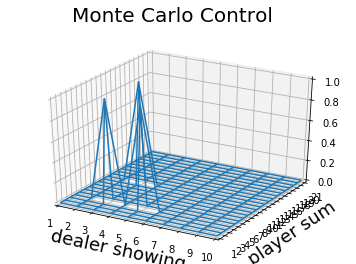

step:1
dealer state:5
player state:4
reward:0
On game.
initial state and action: (5, 4) 0
number, state, action, reward: 0 (5, 4) 0 1
((5, 4), 0) 2
# of games played:2 average reward:0.0
state-action visit number: {((3, 7), 0): 2, ((5, 4), 0): 2, ((8, 5), 1): 1, ((8, 2), 1): 1, ((8, 1), 1): 1, ((5, 4), 1): 1, ((5, 12), 1): 1, ((5, 6), 0): 1, ((3, 4), 1): 1, ((3, 11), 1): 1, ((3, 4), 0): 1}
action value function: {((3, 7), 0): -1.0, ((5, 4), 0): 1.0, ((8, 5), 1): -1.0, ((8, 2), 1): -1.0, ((8, 1), 1): -1.0, ((5, 4), 1): -1.0, ((5, 12), 1): -1.0, ((5, 6), 0): -1.0, ((3, 4), 1): 1.0, ((3, 11), 1): 1.0, ((3, 4), 0): 1.0}
step:1
dealer state:8
player state:5
reward:0
On game.
initial state and action: (8, 5) 1
state, reward, is_finish (8, 2) 0 False
(8, 2) 1
(8, 1) 0 False
state, reward, is_finish (8, 1) 0 False
(8, 1) 1
(8, -2) -1 True
number, state, action, reward: 0 (8, 5) 1 -1
((8, 5), 1) 2
number, state, action, reward: 1 (8, 2) 1 -1
((8, 2), 1) 2
number, state, action, reward: 2 (8, 1)

action value function: {((3, 7), 0): -1.0, ((5, 4), 0): 1.0, ((8, 5), 1): -1.0, ((8, 2), 1): -1.0, ((8, 1), 1): -1.0, ((5, 4), 1): -1.0, ((5, 12), 1): -1.0, ((5, 6), 0): -0.33333333333333337, ((3, 4), 1): 1.0, ((3, 11), 1): 1.0, ((3, 4), 0): 1.0, ((9, 2), 1): -1.0, ((9, 10), 1): -1.0, ((9, 14), 0): -1.0, ((2, 9), 1): 1.0, ((2, 11), 0): 1.0, ((8, 4), 0): 1.0, ((7, 2), 0): 0.0, ((10, 4), 0): -1.0, ((5, 1), 1): -0.5, ((5, 7), 1): -1.0, ((5, 12), 0): -1.0, ((8, 10), 0): 1.0, ((8, 6), 1): -1.0, ((8, 8), 0): -1.0, ((8, 4), 1): 1.0, ((8, 11), 1): 1.0, ((8, 15), 0): 1.0, ((6, 4), 1): -1.0, ((6, 6), 0): -1.0, ((10, 4), 1): -1.0, ((10, 6), 0): -1.0, ((4, 8), 0): 1.0, ((2, 4), 1): -1.0, ((2, 14), 1): -1.0, ((2, 15), 0): -1.0, ((8, 3), 0): -1.0, ((4, 10), 0): -1.0, ((6, 5), 0): -1.0, ((5, 7), 0): -1.0, ((2, 8), 1): 1.0, ((2, 17), 0): 1.0, ((10, 2), 0): -1.0, ((7, 9), 1): 1.0, ((7, 4), 1): 1.0, ((7, 5), 0): 1.0, ((1, 1), 0): 1.0, ((10, 10), 0): -1.0, ((6, 2), 0): -1.0, ((4, 1), 1): 1.0, ((4, 7), 0)

state, reward, is_finish (4, 10) 0 False
(4, 10) 1
(4, 1) 0 False
state, reward, is_finish (4, 1) 0 False
(4, 1) 1
(4, 3) 0 False
state, reward, is_finish (4, 3) 0 False
(4, 3) 0
(18, 3) -1 True
number, state, action, reward: 0 (4, 1) 1 -1
((4, 1), 1) 2
number, state, action, reward: 1 (4, 10) 1 -1
((4, 10), 1) 2
number, state, action, reward: 2 (4, 1) 1 -1
((4, 1), 1) 3
number, state, action, reward: 3 (4, 3) 0 -1
# of games played:100 average reward:-0.18
state-action visit number: {((3, 7), 0): 2, ((5, 4), 0): 2, ((8, 5), 1): 2, ((8, 2), 1): 2, ((8, 1), 1): 2, ((5, 4), 1): 5, ((5, 12), 1): 3, ((5, 6), 0): 5, ((3, 4), 1): 2, ((3, 11), 1): 2, ((3, 4), 0): 3, ((9, 2), 1): 1, ((9, 10), 1): 2, ((9, 14), 0): 1, ((2, 9), 1): 1, ((2, 11), 0): 1, ((8, 4), 0): 2, ((7, 2), 0): 2, ((10, 4), 0): 2, ((5, 1), 1): 4, ((5, 7), 1): 1, ((5, 12), 0): 1, ((8, 10), 0): 1, ((8, 6), 1): 1, ((8, 8), 0): 3, ((8, 4), 1): 1, ((8, 11), 1): 1, ((8, 15), 0): 1, ((6, 4), 1): 1, ((6, 6), 0): 1, ((10, 4), 1): 1, ((1

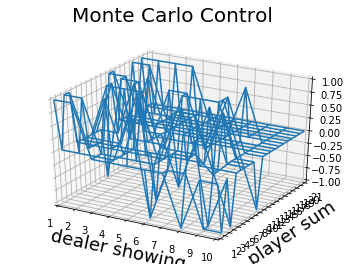

In [4]:

mcc = MCControl()
#mcc.simulate_once()
mcc.simulate(100)
mcc.showV()

In [ ]:
mc = MCControl()

In [ ]:
mc.simulate_once()